In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import keras
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import graphviz
import pydot
import sys

In [3]:
import warnings
warnings.filterwarnings('always')

In [25]:
sys.path.insert(0, '..')
from data_wrangling import create_new_folder
from modeling_results import pred_results, plot_confusion_matrix
from cnn_model import *
from resnet50 import *

In [5]:
#generate a dataset
train = r'../train_images'
val = r'../val_images'
test = r'../test_images'

In [6]:
image_size = (200, 200) #(height, width)
batch_size = 32
num_classes = len(os.listdir(train))

train_gen = ImageDataGenerator(rescale=1./255, 
                               shear_range=0.1,
                               zoom_range=0.1, 
                               horizontal_flip=True, 
                               fill_mode='reflect'
                              )

val_gen = ImageDataGenerator(rescale=1./255)

test_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_gen.flow_from_directory(directory=train, 
                                              target_size=image_size,
                                              color_mode='rgb',
                                              class_mode='categorical', 
                                              batch_size = batch_size,
                                              seed=42)

validation_generator = val_gen.flow_from_directory(directory=val, 
                                                   target_size=image_size,
                                                   color_mode='rgb',
                                                   class_mode='categorical', 
                                                   batch_size = batch_size,
                                                   seed=42)

test_generator = test_gen.flow_from_directory(directory=test, 
                                              target_size=image_size,
                                              color_mode='rgb',
                                              class_mode='categorical', 
                                              batch_size = 1,
                                              shuffle = False,
                                                   seed=42)

Found 1250 images belonging to 6 classes.
Found 206 images belonging to 6 classes.
Found 230 images belonging to 6 classes.


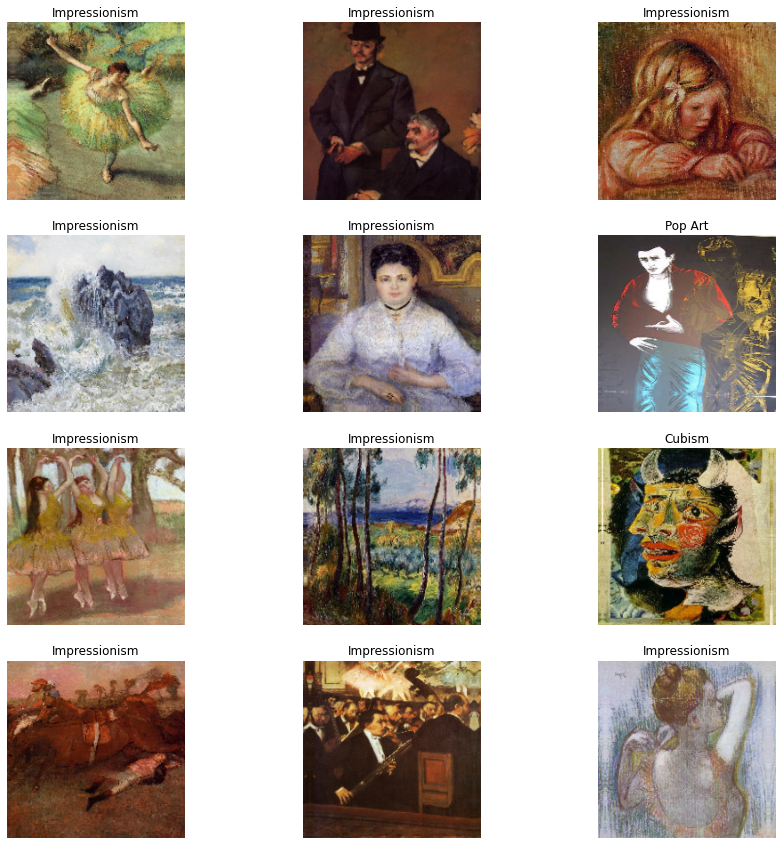

In [7]:
plt.figure(figsize=(15,15))

x, y = train_generator.__getitem__(10) #returns batch of size 32; arg is a random sequence of the batch
x = x.reshape((1,)+x.shape)
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
y = [np.argmax(i) for i in y]
y = [labels[k] for k in y]

for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    image = x[0][i]
    plt.imshow(image)
    plt.title(y[i])
    plt.axis("off")

In [8]:
modelpath = r'../models/model'
epochs = 25

# CNN MODEL

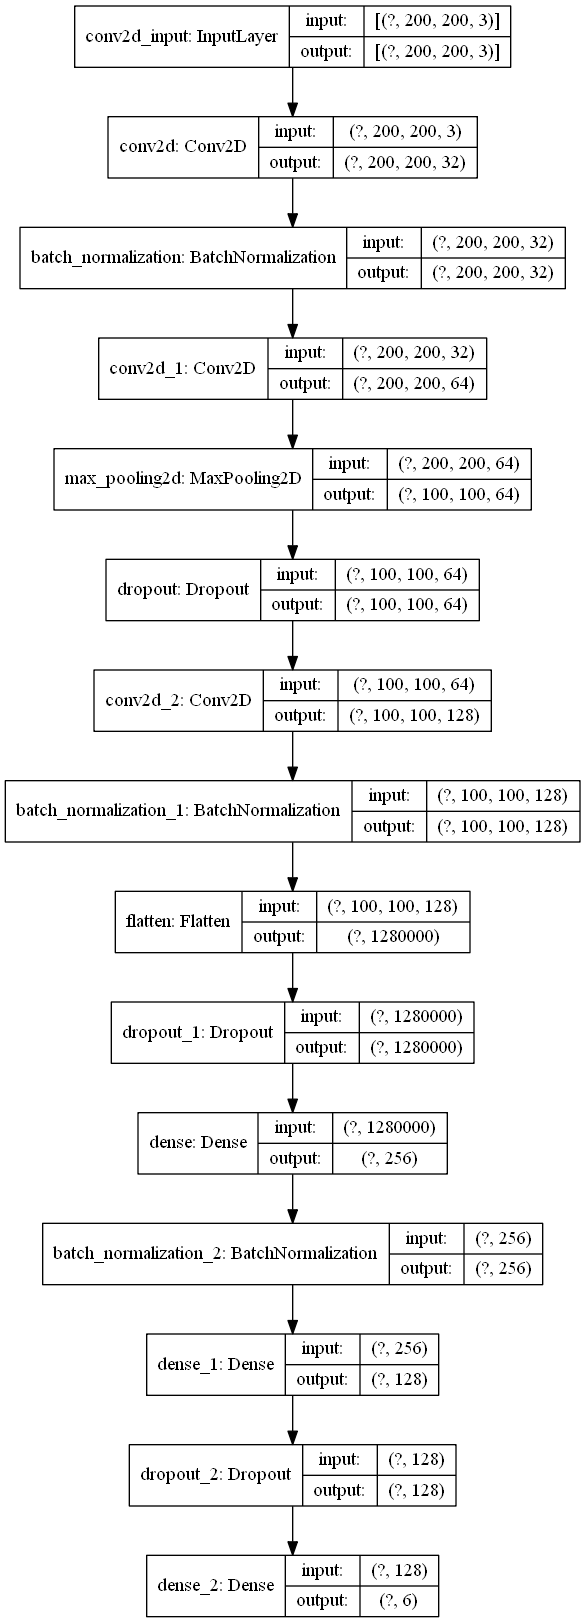

In [10]:
model = cnn_model(input_shape=image_size + (3,), num_classes=num_classes)
keras.utils.plot_model(model, show_shapes=True)

In [20]:
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(modelpath,f'model_cnn_checkpoint_{epochs}.h5')),]

model.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy']
                 )

model.fit(train_generator,
              epochs=epochs,
              callbacks=callbacks,
              validation_data=validation_generator,)

Epoch 1/25
40/40 [==============================] - 990s 25s/step - loss: 1.4498 - accuracy: 0.5208 - val_loss: 1.2360 - val_accuracy: 0.6019
Epoch 2/25
40/40 [==============================] - 1154s 29s/step - loss: 0.9503 - accuracy: 0.6512 - val_loss: 1.2220 - val_accuracy: 0.5971
Epoch 3/25
40/40 [==============================] - 1336s 33s/step - loss: 0.8385 - accuracy: 0.6968 - val_loss: 1.3814 - val_accuracy: 0.5971
Epoch 4/25
40/40 [==============================] - 1089s 27s/step - loss: 0.7288 - accuracy: 0.7424 - val_loss: 1.2321 - val_accuracy: 0.6019
Epoch 5/25
40/40 [==============================] - 1285s 32s/step - loss: 0.8264 - accuracy: 0.6968 - val_loss: 1.6845 - val_accuracy: 0.4369
Epoch 6/25
40/40 [==============================] - 1315s 33s/step - loss: 0.8256 - accuracy: 0.6952 - val_loss: 1.1161 - val_accuracy: 0.6408
Epoch 7/25
40/40 [==============================] - 1170s 29s/step - loss: 0.7437 - accuracy: 0.7328 - val_loss: 1.2216 - val_accuracy: 0.5971


In [21]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 200, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 128)     73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 128)     5

In [32]:
model.evaluate(validation_generator)

7/7 [==============================] - 6s 838ms/step - loss: 14.6549 - accuracy: 0.0874


[14.654911041259766, 0.08737864345312119]

In [26]:
test_generator.reset()
pred = model.predict(test_generator, verbose=1)
results = pred_results(train_generator, test_generator, pred, 'cnn_model_results')

230/230 [==============================] - 45s 195ms/step


In [28]:
predicted_classes = np.argmax(pred, axis=1)
cm = confusion_matrix(test_generator.classes, predicted_classes)
classification_report(test_generator.classes, predicted_classes, target_names=os.listdir(train))

C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

'                        precision    recall  f1-score   support\n\nAbstract Expressionism       0.00      0.00      0.00         2\n         Byzantine Art       0.00      0.00      0.00        10\n                Cubism       0.75      0.14      0.23        44\n         Expressionism       0.00      0.00      0.00        19\n         Impressionism       0.00      0.00      0.00       137\n               Pop Art       0.08      0.94      0.14        18\n\n              accuracy                           0.10       230\n             macro avg       0.14      0.18      0.06       230\n          weighted avg       0.15      0.10      0.06       230\n'

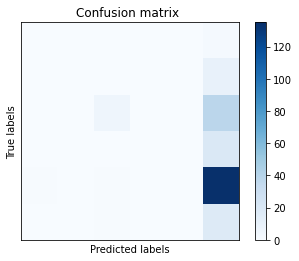

In [29]:
plot_confusion_matrix(cm)

In [31]:
results[['True_Label', 'Predictions']].value_counts()

True_Label              Predictions           
Impressionism           Pop Art                   135
Cubism                  Pop Art                    38
Expressionism           Pop Art                    19
Pop Art                 Pop Art                    17
Byzantine Art           Pop Art                    10
Cubism                  Cubism                      6
Abstract Expressionism  Pop Art                     2
Pop Art                 Cubism                      1
Impressionism           Cubism                      1
                        Abstract Expressionism      1
dtype: int64

# WEIGHTED CNN MODEL

In [41]:
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(train_generator.labels), y=train_generator.labels)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [42]:
wmodel = cnn_model(input_shape=image_size + (3,), num_classes=num_classes)

In [43]:
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(modelpath,f'model_cnnweighted_checkpoint_{epochs}.h5')),]

wmodel.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy']
                 )

wmodel.fit(train_generator,
          epochs=epochs,
          callbacks=callbacks,
          validation_data=validation_generator,
          class_weight=class_weights)



Epoch 1/25
40/40 [==============================] - 974s 24s/step - loss: 1.8821 - accuracy: 0.2896 - val_loss: 1.6222 - val_accuracy: 0.3155
Epoch 2/25
40/40 [==============================] - 944s 24s/step - loss: 1.1614 - accuracy: 0.4376 - val_loss: 1.3464 - val_accuracy: 0.5777
Epoch 3/25
40/40 [==============================] - 940s 24s/step - loss: 0.9448 - accuracy: 0.5480 - val_loss: 1.4787 - val_accuracy: 0.4612
Epoch 4/25
40/40 [==============================] - 831s 21s/step - loss: 0.9187 - accuracy: 0.5808 - val_loss: 1.5392 - val_accuracy: 0.4515
Epoch 5/25
40/40 [==============================] - 859s 21s/step - loss: 0.9253 - accuracy: 0.5864 - val_loss: 1.3395 - val_accuracy: 0.4320
Epoch 6/25
40/40 [==============================] - 986s 25s/step - loss: 0.8195 - accuracy: 0.6072 - val_loss: 1.4132 - val_accuracy: 0.5874
Epoch 7/25
40/40 [==============================] - 929s 23s/step - loss: 0.7960 - accuracy: 0.6464 - val_loss: 1.3025 - val_accuracy: 0.5437
Epoch 

In [44]:
print(wmodel.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 200, 200, 32)      896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 200, 200, 32)      128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 200, 200, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 100, 100, 64)      0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 100, 100, 128)     73856     
_________________________________________________________________
batch_normalization_10 (Batc (None, 100, 100, 128)    

In [46]:
wmodel.evaluate(validation_generator)

7/7 [==============================] - 6s 836ms/step - loss: 1.4467 - accuracy: 0.4320


[1.446705937385559, 0.4320388436317444]

In [47]:
test_generator.reset()
pred = wmodel.predict(test_generator, verbose=1)
pred_results(train_generator, test_generator, pred, 'cnn_model_weighted_results')

230/230 [==============================] - 46s 202ms/step


,Filename,True_Label,Predictions
0,Abstract Expressionism\Jackson_Pollock_23.jpg,Abstract Expressionism,Pop Art
1,Abstract Expressionism\Jackson_Pollock_24.jpg,Abstract Expressionism,Abstract Expressionism
2,Byzantine Art\Andrei_Rublev_24.jpg,Byzantine Art,Abstract Expressionism
3,Byzantine Art\Andrei_Rublev_36.jpg,Byzantine Art,Byzantine Art
4,Byzantine Art\Andrei_Rublev_37.jpg,Byzantine Art,Abstract Expressionism
...,...,...,...
225,Pop Art\Andy_Warhol_87.jpg,Pop Art,Cubism
226,Pop Art\Andy_Warhol_90.jpg,Pop Art,Pop Art
227,Pop Art\Andy_Warhol_95.jpg,Pop Art,Pop Art
228,Pop Art\Andy_Warhol_96.jpg,Pop Art,Pop Art


In [48]:
predicted_classes = np.argmax(pred, axis=1)
cm = confusion_matrix(test_generator.classes, predicted_classes)
classification_report(test_generator.classes, predicted_classes, target_names=os.listdir(train))

'                        precision    recall  f1-score   support\n\nAbstract Expressionism       0.02      0.50      0.04         2\n         Byzantine Art       0.14      0.40      0.21        10\n                Cubism       0.35      0.50      0.41        44\n         Expressionism       0.54      0.37      0.44        19\n         Impressionism       0.95      0.27      0.42       137\n               Pop Art       0.43      0.83      0.57        18\n\n              accuracy                           0.37       230\n             macro avg       0.40      0.48      0.35       230\n          weighted avg       0.72      0.37      0.42       230\n'

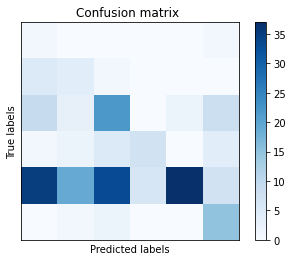

In [49]:
plot_confusion_matrix(cm)

# RESNET50 MODEL

Tensor("input_3:0", shape=(None, 200, 200, 3), dtype=float32) Tensor("fc6/Softmax_2:0", shape=(None, 6), dtype=float32)


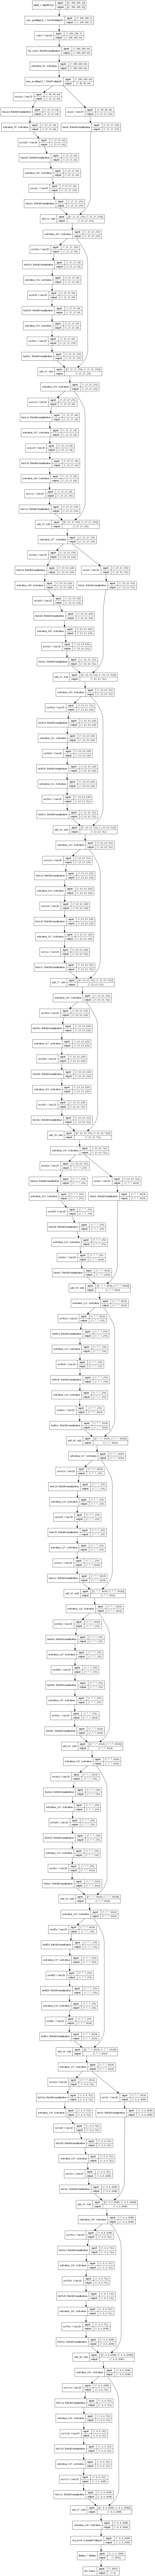

In [33]:
resnet50model = resnet50_model(input_shape=image_size+(3,), num_classes=num_classes)
keras.utils.plot_model(resnet50model, show_shapes=True)

In [34]:
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(modelpath,f'model_resnet50_checkpoint_{epochs}.h5')),]

resnet50model.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy']
                 )

resnet50model.fit(train_generator,
          epochs=epochs,
          callbacks=callbacks,
          validation_data=validation_generator,
          batch_size=batch_size)

Epoch 1/25
40/40 [==============================] - 193s 5s/step - loss: 4.6558 - accuracy: 0.4800 - val_loss: 1.5920 - val_accuracy: 0.1893
Epoch 2/25
40/40 [==============================] - 186s 5s/step - loss: 1.8680 - accuracy: 0.5352 - val_loss: 1.2611 - val_accuracy: 0.5971
Epoch 3/25
40/40 [==============================] - 187s 5s/step - loss: 1.7779 - accuracy: 0.5312 - val_loss: 1.3153 - val_accuracy: 0.5971
Epoch 4/25
40/40 [==============================] - 187s 5s/step - loss: 1.5969 - accuracy: 0.5688 - val_loss: 1.5015 - val_accuracy: 0.3107
Epoch 5/25
40/40 [==============================] - 187s 5s/step - loss: 2.3278 - accuracy: 0.5440 - val_loss: 237.1979 - val_accuracy: 0.5388
Epoch 6/25
40/40 [==============================] - 186s 5s/step - loss: 1.6514 - accuracy: 0.5248 - val_loss: 642.8422 - val_accuracy: 0.1845
Epoch 7/25
40/40 [==============================] - 187s 5s/step - loss: 1.3891 - accuracy: 0.5584 - val_loss: 2.0247 - val_accuracy: 0.5922
Epoch 8/2

In [35]:
print(resnet50model.summary())

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 206, 206, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 100, 100, 64) 9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 100, 100, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [36]:
resnet50model.evaluate(validation_generator)

7/7 [==============================] - 4s 642ms/step - loss: 11.9201 - accuracy: 0.5437


[11.920084953308105, 0.5436893105506897]

In [37]:
test_generator.reset()
rn50pred = resnet50model.predict(test_generator, verbose=1)
pred_results(train_generator, test_generator, rn50pred, 'resnet50_model_results')

230/230 [==============================] - 8s 36ms/step


,Filename,True_Label,Predictions
0,Abstract Expressionism\Jackson_Pollock_23.jpg,Abstract Expressionism,Pop Art
1,Abstract Expressionism\Jackson_Pollock_24.jpg,Abstract Expressionism,Pop Art
2,Byzantine Art\Andrei_Rublev_24.jpg,Byzantine Art,Impressionism
3,Byzantine Art\Andrei_Rublev_36.jpg,Byzantine Art,Pop Art
4,Byzantine Art\Andrei_Rublev_37.jpg,Byzantine Art,Impressionism
...,...,...,...
225,Pop Art\Andy_Warhol_87.jpg,Pop Art,Impressionism
226,Pop Art\Andy_Warhol_90.jpg,Pop Art,Pop Art
227,Pop Art\Andy_Warhol_95.jpg,Pop Art,Pop Art
228,Pop Art\Andy_Warhol_96.jpg,Pop Art,Impressionism


In [38]:
rn50predicted_class_indices=np.argmax(rn50pred,axis=1)

In [39]:
cm=confusion_matrix(test_generator.classes, rn50predicted_class_indices)
classification_report(test_generator.classes, rn50predicted_class_indices, target_names=list(os.listdir(train)))

C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

'                        precision    recall  f1-score   support\n\nAbstract Expressionism       0.00      0.00      0.00         2\n         Byzantine Art       0.00      0.00      0.00        10\n                Cubism       0.22      0.09      0.13        44\n         Expressionism       0.50      0.05      0.10        19\n         Impressionism       0.68      0.76      0.72       137\n               Pop Art       0.16      0.50      0.24        18\n\n              accuracy                           0.51       230\n             macro avg       0.26      0.23      0.20       230\n          weighted avg       0.50      0.51      0.48       230\n'

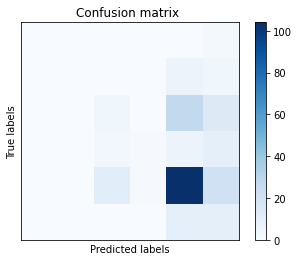

In [40]:
plot_confusion_matrix(cm)

# RESNET50 WEIGHTED MODEL

In [50]:
r50wmodel = resnet50_model(input_shape=image_size+(3,), num_classes=num_classes)

Tensor("input_4:0", shape=(None, 200, 200, 3), dtype=float32) Tensor("fc6/Softmax_3:0", shape=(None, 6), dtype=float32)


In [51]:
#this uses class weights
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(modelpath,f'model_resnet50weighted_checkpoint_{epochs}.h5')),]

r50wmodel.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy']
                 )

r50wmodel.fit(train_generator,
          epochs=epochs,
          callbacks=callbacks,
          validation_data=validation_generator,
          class_weight=class_weights)

Epoch 1/25
40/40 [==============================] - 189s 5s/step - loss: 5.0110 - accuracy: 0.1984 - val_loss: 43.6325 - val_accuracy: 0.0825
Epoch 2/25
40/40 [==============================] - 186s 5s/step - loss: 2.0690 - accuracy: 0.2920 - val_loss: 11.0692 - val_accuracy: 0.5971
Epoch 3/25
40/40 [==============================] - 186s 5s/step - loss: 1.6757 - accuracy: 0.3408 - val_loss: 1.7175 - val_accuracy: 0.5825
Epoch 4/25
40/40 [==============================] - 187s 5s/step - loss: 3.3836 - accuracy: 0.3488 - val_loss: 1.3706 - val_accuracy: 0.5971
Epoch 5/25
40/40 [==============================] - 187s 5s/step - loss: 1.6544 - accuracy: 0.3248 - val_loss: 1.4911 - val_accuracy: 0.5971
Epoch 6/25
40/40 [==============================] - 186s 5s/step - loss: 1.5153 - accuracy: 0.4128 - val_loss: 55.3627 - val_accuracy: 0.2913
Epoch 7/25
40/40 [==============================] - 187s 5s/step - loss: 1.2691 - accuracy: 0.4800 - val_loss: 1.4501 - val_accuracy: 0.4223
Epoch 8/25

In [52]:
print(r50wmodel.summary())

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 206, 206, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 100, 100, 64) 9472        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 100, 100, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [53]:
r50wmodel.evaluate(validation_generator, verbose=1) 

7/7 [==============================] - 4s 626ms/step - loss: 2.3118 - accuracy: 0.3447


[2.3117966651916504, 0.3446601927280426]

In [54]:
test_generator.reset()
pred = r50wmodel.predict(test_generator, verbose=1)
pred_results(train_generator, test_generator, pred, 'resnet50_model_weighted_results')

230/230 [==============================] - 8s 36ms/step


,Filename,True_Label,Predictions
0,Abstract Expressionism\Jackson_Pollock_23.jpg,Abstract Expressionism,Pop Art
1,Abstract Expressionism\Jackson_Pollock_24.jpg,Abstract Expressionism,Pop Art
2,Byzantine Art\Andrei_Rublev_24.jpg,Byzantine Art,Impressionism
3,Byzantine Art\Andrei_Rublev_36.jpg,Byzantine Art,Byzantine Art
4,Byzantine Art\Andrei_Rublev_37.jpg,Byzantine Art,Impressionism
...,...,...,...
225,Pop Art\Andy_Warhol_87.jpg,Pop Art,Pop Art
226,Pop Art\Andy_Warhol_90.jpg,Pop Art,Pop Art
227,Pop Art\Andy_Warhol_95.jpg,Pop Art,Pop Art
228,Pop Art\Andy_Warhol_96.jpg,Pop Art,Pop Art


In [55]:
predicted_class_indices=np.argmax(pred,axis=1)

In [57]:
cm=confusion_matrix(test_generator.classes, predicted_class_indices)
classification_report(test_generator.classes, predicted_class_indices, target_names=os.listdir(train))

'                        precision    recall  f1-score   support\n\nAbstract Expressionism       0.00      0.00      0.00         2\n         Byzantine Art       0.14      0.10      0.12        10\n                Cubism       0.20      0.23      0.21        44\n         Expressionism       0.18      0.11      0.13        19\n         Impressionism       0.75      0.31      0.44       137\n               Pop Art       0.19      0.94      0.32        18\n\n              accuracy                           0.32       230\n             macro avg       0.25      0.28      0.20       230\n          weighted avg       0.52      0.32      0.35       230\n'

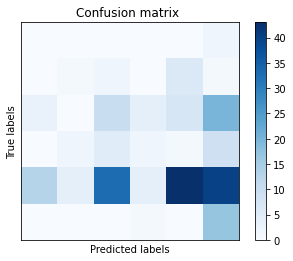

In [58]:
plot_confusion_matrix(cm)